In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


class PageRank:
    """
    PageRank 算法实现类
    """
    
    def __init__(self, beta=0.85, epsilon=1e-8, max_iterations=100):
        """
        初始化 PageRank 参数
        
        参数:
            beta: 阻尼系数 (damping factor)，通常为 0.85
            epsilon: 收敛阈值
            max_iterations: 最大迭代次数
        """
        self.beta = beta
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.graph = defaultdict(list)  # 邻接表
        self.nodes = set()
        self.pagerank_scores = {}
        
    def load_data(self, filepath):
        """
        从 CSV 文件加载图数据
        
        参数:
            filepath: CSV 文件路径
        """
        print(f"正在加载数据: {filepath}")
        df = pd.read_csv(filepath)
        
        # 假设 CSV 格式为: source, target
        if df.shape[1] >= 2:
            source_col = df.columns[0]
            target_col = df.columns[1]
        else:
            raise ValueError("CSV 文件至少需要两列（起点ID，终点ID）")
        
        # 构建图
        for _, row in df.iterrows():
            source = row[source_col]
            target = row[target_col]
            self.graph[source].append(target)
            self.nodes.add(source)
            self.nodes.add(target)
        
        print(f"图加载完成: {len(self.nodes)} 个节点, {len(df)} 条边")
        return self
    
    def build_transition_matrix(self):
        """
        构建转移概率矩阵 P
        """
        n = len(self.nodes)
        node_to_idx = {node: idx for idx, node in enumerate(sorted(self.nodes))}
        self.idx_to_node = {idx: node for node, idx in node_to_idx.items()}
        
        P = np.zeros((n, n))
        
        for node in self.nodes:
            idx = node_to_idx[node]
            out_neighbors = self.graph[node]
            
            if len(out_neighbors) > 0:
                # 有出链的节点：均匀分配概率
                for neighbor in out_neighbors:
                    neighbor_idx = node_to_idx[neighbor]
                    P[neighbor_idx, idx] = 1.0 / len(out_neighbors)
            else:
                # 悬挂节点（dangling node）：均匀分配到所有节点
                P[:, idx] = 1.0 / n
        
        return P, node_to_idx
    
    def compute_pagerank_matrix(self):
        """
        PageRank 公式:
        π = β * P * π + (1-β)/n * 1
        """
        P, node_to_idx = self.build_transition_matrix()
        n = len(self.nodes)
        
        # 初始化 PageRank 向量（均匀分布）
        pi = np.ones(n) / n
        
        print(f"\n开始迭代计算 PageRank (β={self.beta})...")
        
        for iteration in range(self.max_iterations):
            pi_new = self.beta * P @ pi + (1 - self.beta) / n * np.ones(n)
            
            # 检查收敛
            diff = np.linalg.norm(pi_new - pi, ord=1)
            
            if (iteration + 1) % 10 == 0:
                print(f"迭代 {iteration + 1}: 变化量 = {diff:.8f}")
            
            if diff < self.epsilon:
                print(f"收敛于第 {iteration + 1} 次迭代")
                break
            
            pi = pi_new
        
        # 归一化
        pi = pi / pi.sum()
        
        # 保存结果
        self.pagerank_scores = {
            self.idx_to_node[idx]: score 
            for idx, score in enumerate(pi)
        }
        
        return self.pagerank_scores
    
    def get_top_nodes(self, top_k=20):
        """
        获取 PageRank 分数最高的前 k 个节点
        """
        sorted_nodes = sorted(
            self.pagerank_scores.items(), 
            key=lambda x: x[1], 
            reverse=True
        )
        return sorted_nodes[:top_k]
    
    def save_results(self, output_file='pagerank_results.csv'):
        """
        保存 PageRank 结果到 CSV 文件
        """
        df = pd.DataFrame([
            {'Node_ID': node, 'PageRank': score}
            for node, score in sorted(
                self.pagerank_scores.items(), 
                key=lambda x: x[1], 
                reverse=True
            )
        ])
        df.to_csv(output_file, index=False)
        print(f"\n结果已保存到: {output_file}")
        return df
    
    def print_statistics(self):
        """
        打印统计信息
        """
        scores = list(self.pagerank_scores.values())
        print("\n" + "="*60)
        print("PageRank 统计信息")
        print("="*60)
        print(f"节点总数: {len(self.nodes)}")
        print(f"平均 PageRank: {np.mean(scores):.6f}")
        print(f"最大 PageRank: {np.max(scores):.6f}")
        print(f"最小 PageRank: {np.min(scores):.6f}")
        print(f"标准差: {np.std(scores):.6f}")
        print(f"PageRank 总和: {np.sum(scores):.6f}")
        print("="*60)


def visualize_pagerank(pr_obj, top_k=20):
    """
    可视化 PageRank 结果
    """
    top_nodes = pr_obj.get_top_nodes(top_k)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Top K 节点的 PageRank 柱状图
    nodes = [str(node) for node, _ in top_nodes]
    scores = [score for _, score in top_nodes]
    
    axes[0].barh(range(len(nodes)), scores, color='steelblue')
    axes[0].set_yticks(range(len(nodes)))
    axes[0].set_yticklabels(nodes)
    axes[0].set_xlabel('PageRank Score', fontsize=12)
    axes[0].set_ylabel('Node ID', fontsize=12)
    axes[0].set_title(f'Top {top_k} Nodes by PageRank', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # 2. PageRank 分数分布直方图
    all_scores = list(pr_obj.pagerank_scores.values())
    axes[1].hist(all_scores, bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('PageRank Score', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('PageRank Score Distribution', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pagerank_visualization.png', dpi=300, bbox_inches='tight')
    print("\n可视化结果已保存到: pagerank_visualization.png")
    plt.show()


def compare_beta_values(filepath, beta_values=[0.5, 0.75, 0.85, 0.95]):
    """
    比较不同 beta 值对 PageRank 结果的影响
    """
    results = {}
    
    print("\n" + "="*60)
    print("探索不同 β 值的影响")
    print("="*60)
    
    for beta in beta_values:
        print(f"\n{'='*60}")
        print(f"计算 β = {beta} 的 PageRank")
        print(f"{'='*60}")
        
        pr = PageRank(beta=beta, epsilon=1e-8, max_iterations=100)
        pr.load_data(filepath)
        pr.compute_pagerank_matrix()
        
        results[beta] = pr.get_top_nodes(20)
    
    # 可视化不同 beta 值的影响
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, beta in enumerate(beta_values):
        top_nodes = results[beta]
        nodes = [str(node) for node, _ in top_nodes]
        scores = [score for _, score in top_nodes]
        
        axes[idx].barh(range(len(nodes)), scores, color=f'C{idx}')
        axes[idx].set_yticks(range(len(nodes)))
        axes[idx].set_yticklabels(nodes, fontsize=8)
        axes[idx].set_xlabel('PageRank Score', fontsize=10)
        axes[idx].set_title(f'β = {beta}', fontsize=12, fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pagerank_beta_comparison.png', dpi=300, bbox_inches='tight')
    print("\nβ值比较结果已保存到: pagerank_beta_comparison.png")
    plt.show()
    
    return results

正在加载数据: PageRank_Dataset.csv
图加载完成: 7624 个节点, 27806 条边

开始迭代计算 PageRank (β=0.85)...
迭代 10: 变化量 = 0.00010693
迭代 20: 变化量 = 0.00000001
收敛于第 20 次迭代

PageRank 统计信息
节点总数: 7624
平均 PageRank: 0.000131
最大 PageRank: 0.007403
最小 PageRank: 0.000055
标准差: 0.000225
PageRank 总和: 1.000000

PageRank 分数最高的 20 个节点
 1. Node 7237: 0.00740342
 2. Node 7498: 0.00669226
 3. Node 7339: 0.00637877
 4. Node 7162: 0.00317726
 5. Node 7224: 0.00293076
 6. Node 7435: 0.00275113
 7. Node 6519: 0.00271756
 8. Node 7100: 0.00259440
 9. Node 7595: 0.00257613
10. Node 7199: 0.00257569
11. Node 4811: 0.00243469
12. Node 6101: 0.00230890
13. Node 7536: 0.00223911
14. Node 4785: 0.00221205
15. Node 7489: 0.00197029
16. Node 7587: 0.00184996
17. Node 7488: 0.00183503
18. Node 6617: 0.00176548
19. Node 7226: 0.00173878
20. Node 7416: 0.00172525

结果已保存到: pagerank_results.csv

可视化结果已保存到: pagerank_visualization.png


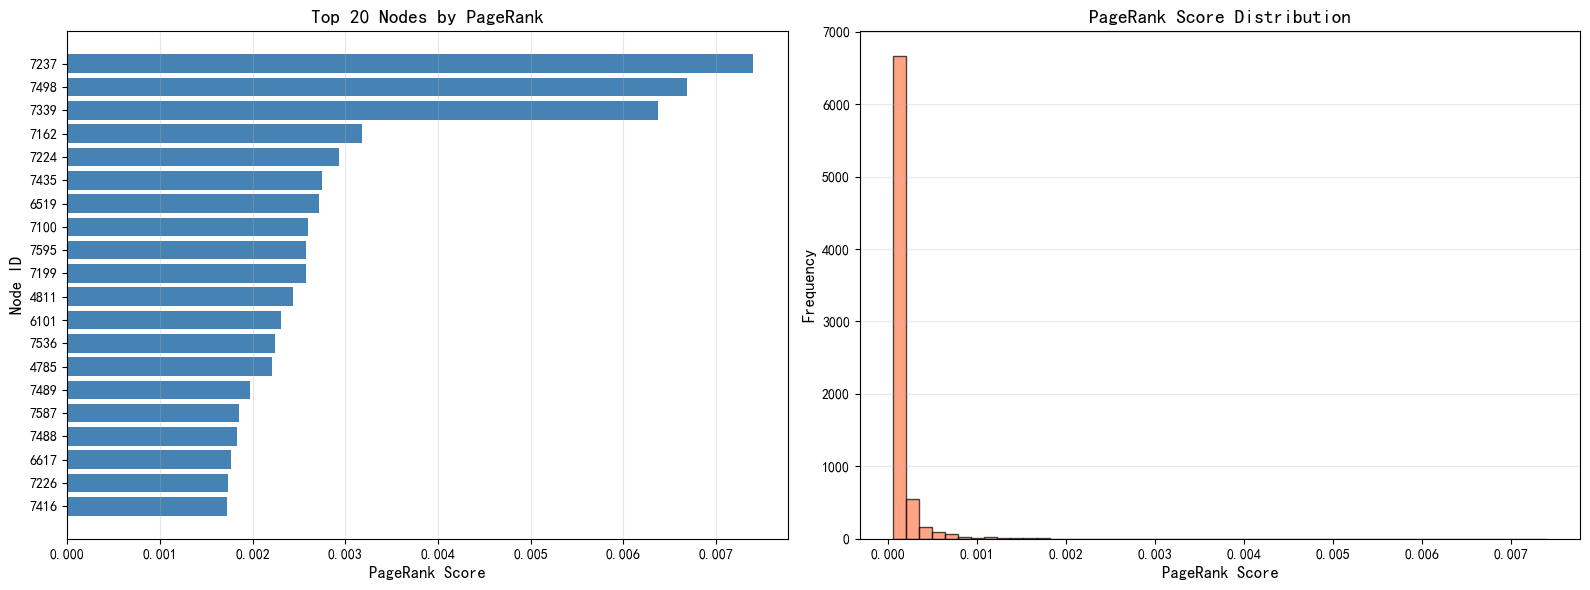

In [3]:
# 数据文件路径
data_file = 'PageRank_Dataset.csv'

# PageRank 计算 (β=0.85)

pr = PageRank(beta=0.85, epsilon=1e-8, max_iterations=100)
pr.load_data(data_file)

# 计算 PageRank
pr.compute_pagerank_matrix()

# 打印统计信息
pr.print_statistics()

# 输出 Top 20 节点
print("\n" + "="*60)
print("PageRank 分数最高的 20 个节点")
print("="*60)
top_20 = pr.get_top_nodes(20)
for rank, (node, score) in enumerate(top_20, 1):
    print(f"{rank:2d}. Node {node}: {score:.8f}")

# 保存完整结果
df_results = pr.save_results('pagerank_results.csv')

# 可视化结果
visualize_pagerank(pr, top_k=20)


探索不同 β 值的影响

计算 β = 0.5 的 PageRank
正在加载数据: PageRank_Dataset.csv
图加载完成: 7624 个节点, 27806 条边

开始迭代计算 PageRank (β=0.5)...
迭代 10: 变化量 = 0.00000053
收敛于第 13 次迭代

计算 β = 0.75 的 PageRank
正在加载数据: PageRank_Dataset.csv
图加载完成: 7624 个节点, 27806 条边

开始迭代计算 PageRank (β=0.75)...
迭代 10: 变化量 = 0.00003059
收敛于第 18 次迭代

计算 β = 0.85 的 PageRank
正在加载数据: PageRank_Dataset.csv
图加载完成: 7624 个节点, 27806 条边

开始迭代计算 PageRank (β=0.85)...
迭代 10: 变化量 = 0.00010693
迭代 20: 变化量 = 0.00000001
收敛于第 20 次迭代

计算 β = 0.95 的 PageRank
正在加载数据: PageRank_Dataset.csv
图加载完成: 7624 个节点, 27806 条边

开始迭代计算 PageRank (β=0.95)...
迭代 10: 变化量 = 0.00032519
迭代 20: 变化量 = 0.00000007
收敛于第 23 次迭代

β值比较结果已保存到: pagerank_beta_comparison.png


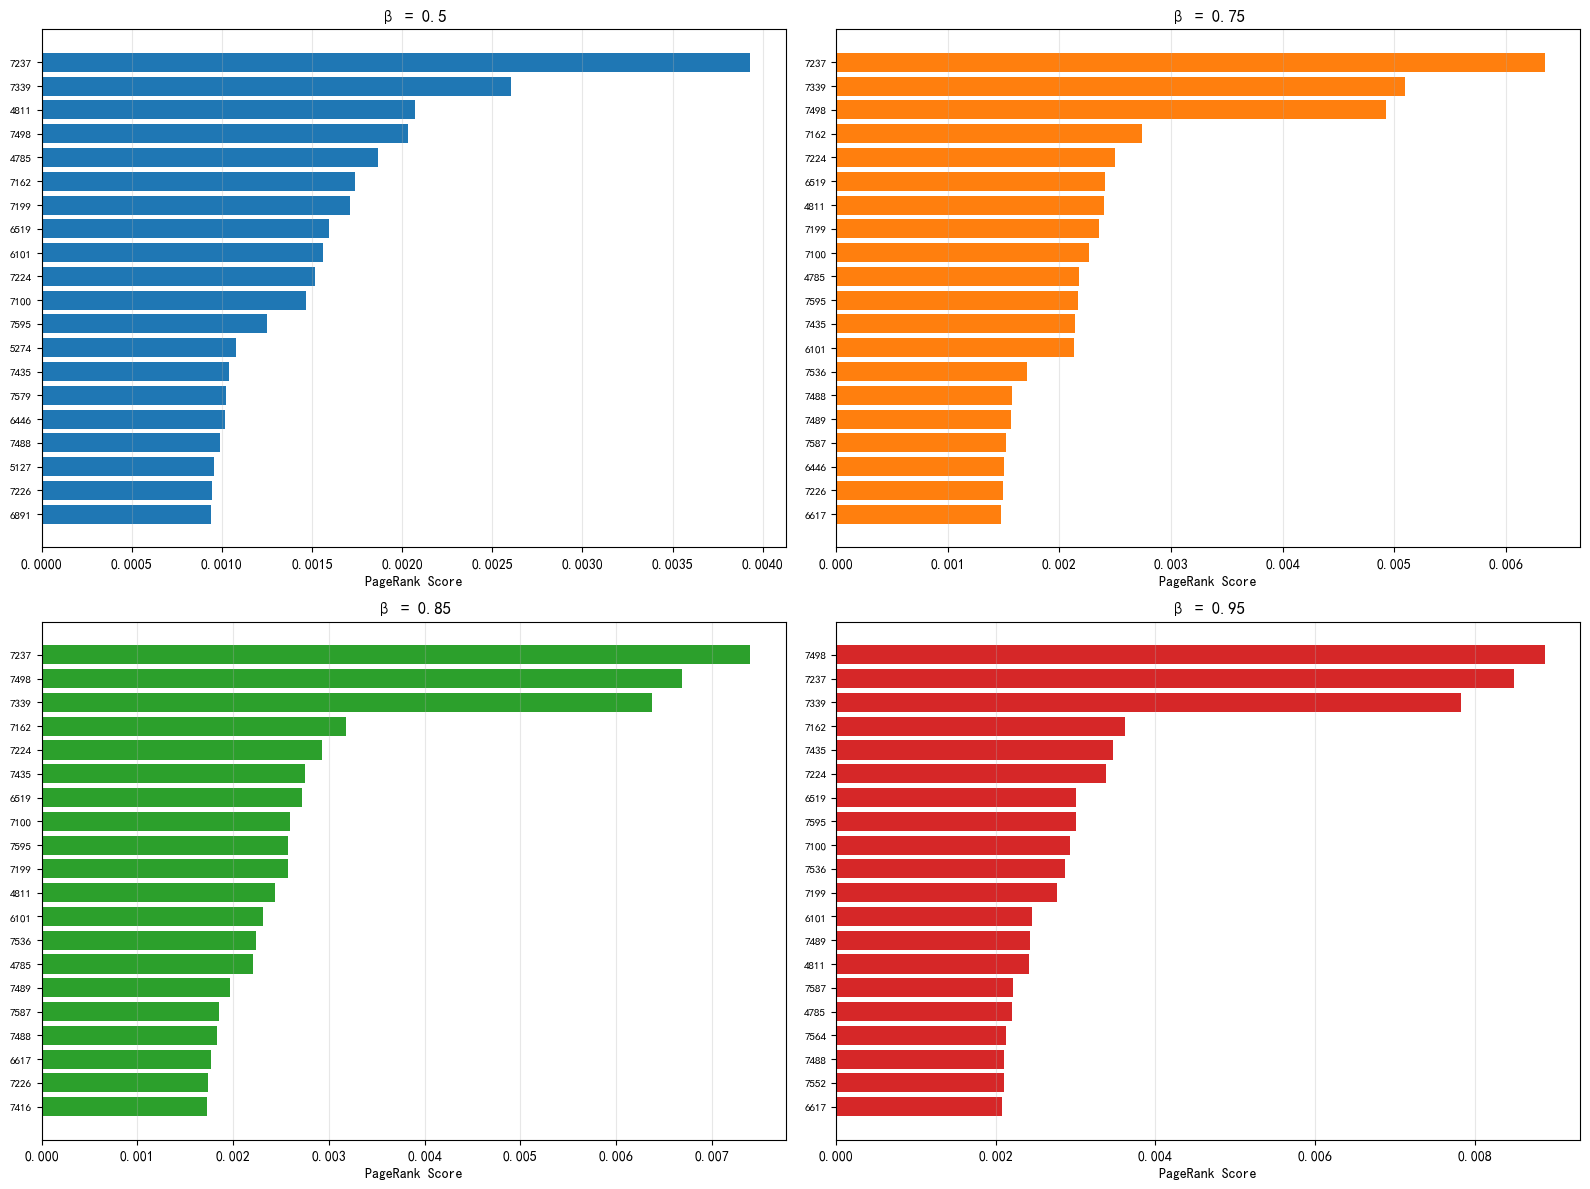


不同 β 值下的 Top 5 节点对比

β = 0.5:
  1. Node 7237: 0.00393129
  2. Node 7339: 0.00260584
  3. Node 4811: 0.00207210
  4. Node 7498: 0.00203195
  5. Node 4785: 0.00186741

β = 0.75:
  1. Node 7237: 0.00634750
  2. Node 7339: 0.00509540
  3. Node 7498: 0.00493131
  4. Node 7162: 0.00274423
  5. Node 7224: 0.00249519

β = 0.85:
  1. Node 7237: 0.00740342
  2. Node 7498: 0.00669226
  3. Node 7339: 0.00637877
  4. Node 7162: 0.00317726
  5. Node 7224: 0.00293076

β = 0.95:
  1. Node 7498: 0.00887595
  2. Node 7237: 0.00849767
  3. Node 7339: 0.00783528
  4. Node 7162: 0.00361913
  5. Node 7435: 0.00346659


In [4]:
# Optional: 探索不同 beta 值的影响

beta_results = compare_beta_values(
    data_file, 
    beta_values=[0.5, 0.75, 0.85, 0.95]
)

# 打印不同 beta 值下的 Top 5 节点
print("\n" + "="*60)
print("不同 β 值下的 Top 5 节点对比")
print("="*60)
for beta, top_nodes in beta_results.items():
    print(f"\nβ = {beta}:")
    for rank, (node, score) in enumerate(top_nodes[:5], 1):
        print(f"  {rank}. Node {node}: {score:.8f}")
